This tutorial demonstrates a basic usage of the image formation pipeline in `cryojax`.

In [1]:
# Jax imports
import jax

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

First, import the `cryojax` simulator. We will import this with the import hooks from `jaxtyping`, which will give our functions run-time type checking capability. See [here](https://docs.kidger.site/jaxtyping/api/runtime-type-checking/#runtime-type-checking) to learn more.

In [3]:
# CryoJAX imports
import cryojax.simulator as cxs

First we must read in our 3D scattering potential into a given voxel-based representation of the `potential`. Here, this is the `FourierVoxelGridPotential`. Then, the representation of a biological specimen is instantiated, which also includes a pose and conformational heterogeneity. Here, the `SingleStructureEnsemble` class is used, which does not model heterogeneity.

In [4]:
from cryojax.io import read_array_with_spacing_from_mrc


# Scattering potential stored in MRC format
filename = "./data/groel_5w0s_scattering_potential.mrc"
# Read template into a FourierVoxelGridPotential
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)
# ... now, instantiate the pose. Angles are given in degrees
pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    phi_angle=20.0,
    theta_angle=80.0,
    psi_angle=-5.0,
)
# ... now, build the ensemble. In this case, the ensemble is just one potential and a
# pose
structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)

To see how the array stored in `filename` was written, see the documentation [here](https://mjo22.github.io/cryojax/examples/compute-potential/).

Next, build the *scattering theory*. The simplest `scattering_theory` is the `WeakPhaseScatteringTheory`. This represents the usual image formation pipeline in cryo-EM, which forms images by integrating the potential and convolving the result with a contrast transfer function.

In [ ]:
# Initialize the scattering theory. First, instantiate fourier slice extraction
potential_integrator = cxs.FourierSliceExtraction()
# ... next, the contrast transfer theory
ctf = cxs.CTF(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
)
transfer_theory = cxs.ContrastTransferTheory(ctf, amplitude_contrast_ratio=0.1)
# ... now for the scattering theory
scattering_theory = cxs.WeakPhaseScatteringTheory(
    structural_ensemble, potential_integrator, transfer_theory, solvent=None
)

Finally, we create an `InstrumentConfig` and initialize our `AbstractImageModel`. Here, we select the `ContrastImageModel`, which simulates the image contrast given a `scattering_theory`.

In [6]:
# Create the instrument configuration
instrument_config = cxs.InstrumentConfig(
    shape=(80, 80),
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
    padded_shape=potential.shape[:2],
)
# ... now, build the image formation model
image_model = cxs.ContrastImageModel(instrument_config, scattering_theory)

Before proceeding, we must create JIT compiled function that simulate our images. We can simulate with the `ContrastImageModel.render` function.

!!! info

    The `ContrastImageModel.render` function may optionally take in an RNG key

    ```python
    import jax.random as jr

    rng_key = jr.key(seed=1234)
    image_model = ContrastImageModel(...)
    image = image_model.render(rng_key=rng_key)
    ```

    This is because an `image_model` may have components that are stochastic.
    For example, the `WeakPhaseScatteringTheory` may optionally take in a model
    for the solvent, and the `ElectronCountsImageModel` takes in a model for a detector.
    If an `image_model` has stochastic components but `render` is not called with an
    RNG key, then the determistic part of the model is computed. 

In [7]:
import equinox as eqx
from jaxtyping import PRNGKeyArray


@eqx.filter_jit
def compute_image(image_model: cxs.AbstractImageModel):
    """Simulate an image without noise from a `image_model`."""
    return image_model.render()

**What's with the eqx.filter_jit?**

This is an example of an equinox *filtered transformation*. In this case, the `eqx.filter_jit` decorator is a lightweight wrapper around `jax.jit` that treats all of the `image_model`'s JAX arrays as traced at compile time, and all of its non-JAX arrays as static. Alternatively, we could have used the usual `jax.jit` decorator and explicitly passed traced and static pytrees to our function. It is completely optional to use `equinox` decorators.

Filtered transformations are a cornerstone to `equinox` and it is highly recommended to learn about them. See [here](https://docs.kidger.site/equinox/all-of-equinox/#2-filtering) in the equinox documentation for an introduction.

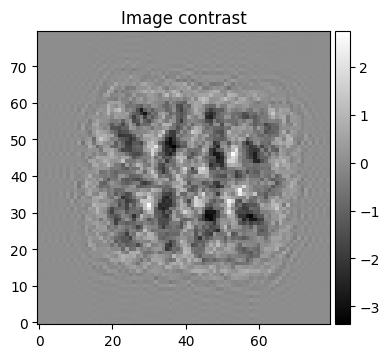

In [8]:
# Simulate each image, drawing from the stochastic parts of the model
key = jax.random.key(0)
fig, ax = plt.subplots(figsize=(4, 4))
im1 = plot_image(
    compute_image(image_model),
    fig,
    ax,
    label="Image contrast",
)
plt.tight_layout()

Alternatively, the user can simulate an image with noise from the `cryojax.inference.distributions` module. In this example, we use the `IndependentGaussianPixels` distribution, which simulates images with white noise. Whereas an `image_model` is meant to simulate images in physical units, `distributions` have phenomenological parameters and have built-in functionality for normalization.

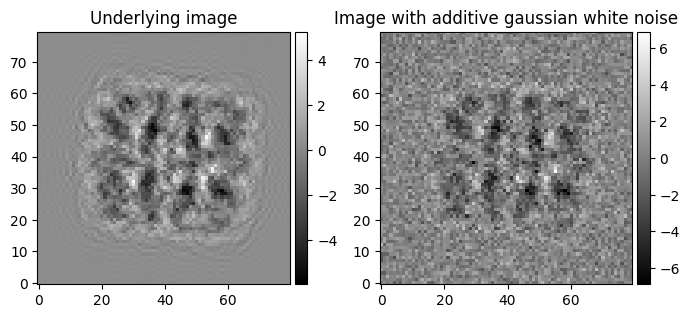

In [9]:
from cryojax.inference import distributions as dist


@eqx.filter_jit
def compute_image_with_distribution(distribution: dist.AbstractDistribution):
    """Simulate an image with noise from a `image_model`."""
    return distribution.compute_signal()


@eqx.filter_jit
def compute_noisy_image_with_distribution(
    distribution: dist.AbstractDistribution, key: PRNGKeyArray
):
    """Simulate an image with noise from a `image_model`."""
    return distribution.sample(key)


# Passing the ImagePipeline and a variance function, instantiate the distribution
distribution = dist.IndependentGaussianPixels(
    image_model,
    signal_scale_factor=1.0,
    variance=1.0,
    normalizes_signal=True,
)
# ... then, either simulate an image from this distribution
key = jax.random.key(seed=0)

fig, axes = plt.subplots(ncols=2, figsize=(7, 4))
ax1, ax2 = axes
im1 = plot_image(
    compute_image_with_distribution(distribution),
    fig,
    ax1,
    label="Underlying image",
)
im2 = plot_image(
    compute_noisy_image_with_distribution(distribution, key),
    fig,
    ax2,
    label="Image with additive gaussian white noise",
)
plt.tight_layout()

Here, we can directly control image SNR through the parameters `distribution.signal_scale_factor` (a phenomenological scale factor for the underlying signal) and `distribution.variance` (the variance of the additive gaussian white noise).

`cryojax` also can simulate images with non-white gaussian noise using the `IndependentGaussianFourierModes` distribution. See the documentation for more information.